In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier as RFC

## Read files

In [3]:
%%time
train_transaction = pd.read_csv('newtrain_transaction_200000.csv', index_col='TransactionID')
test_transaction = pd.read_csv('newtest_transaction_withoutlabel.csv', index_col='TransactionID')

train_identity = pd.read_csv('newtrain_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('newtest_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('newsample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity

# Drop target
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test

(80397, 433)
(10000, 432)
Wall time: 5.27 s


In [4]:
#备份数据集 copy the dataset
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
X_test_copy = X_test.copy()

In [5]:
#按缺失比例移除某列  remove the feature
def remove_the_null(data,data1,a):  
    for col_name in data.columns:
        num = len(data[col_name])
        cnt = list(data[col_name].isna()).count(True)
        if (cnt / num > a):
            del data[col_name]
            del data1[col_name]
            
#    return data1

In [6]:
#用众数填补缺失值  fillna 
def fill_na_df(X_train, X_test): 
    for col_name in X_train.columns: 
        X_train[col_name].fillna(X_train[col_name].mode()[0], inplace=True)
        X_test[col_name].fillna(X_test[col_name].mode()[0], inplace=True)

## Remove the unimportant feature

In [7]:
#按缺失比例移除某列  remove the feature 
remove_the_null(X_train, X_test,0.375)

In [8]:
#用众数填补缺失值  fillna
fill_na_df(X_train, X_test)

In [9]:
print(X_test.shape)
print(X_train.shape)

(10000, 180)
(80397, 180)


In [10]:
#将字符类型转换为数字 labelencoding
def label_encoding(X_train, X_test):
    for f in X_train.columns:
        if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train[f].values) + list(X_test[f].values))
            X_train[f] = lbl.transform(list(X_train[f].values))
            X_test[f] = lbl.transform(list(X_test[f].values))
    return X_train, X_test

## label encoding

In [11]:
X_train,X_test = label_encoding(X_train, X_test)

In [12]:
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

## split the dataset

In [24]:
#train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X_train,y_train,test_size = 0.3)

## use the learning curve to find the best hyperparameter

In [25]:
#绘制学习曲线 找n_estimators  use learning_curve to find the best n_estimator
score = []
for i in range(0,200,10):
    clf = RFC(n_estimators=i+1,random_state=0).fit(xtrain,ytrain)
    pre_ = clf.predict(xtest)
    once = roc_auc_score(ytest,pre_)
    #once = cross_val_score(RFC(n_estimators=i+1,random_state=0),X_train,y_train,cv=10).mean()
    score.append(once)

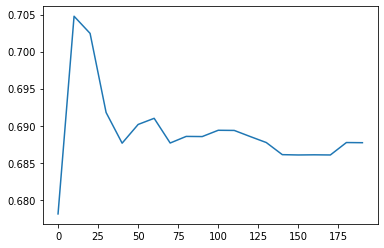

In [26]:
plt.plot(range(0,200,10),score)
plt.show()

In [27]:
print(max(score), score.index(max(score))*10)

0.7047664602598315 10


In [28]:
#use learning_curve to find the best max_depth
score1 = []
for i in range(30,50,1):
    clf = RFC(n_estimators=10,max_depth=i,random_state=0).fit(xtrain,ytrain)
    pre_ = clf.predict(xtest)
    once = roc_auc_score(ytest,pre_)
    #once = cross_val_score(RFC(n_estimators=i+1,random_state=0),X_train,y_train,cv=10).mean()
    score1.append(once)

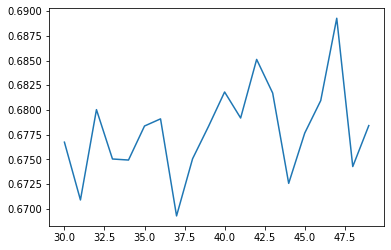

In [29]:
plt.plot(range(30,50,1),score1)
plt.show()

In [21]:
rfc = RFC(n_estimators=30,max_depth=34, random_state=0).fit(xtrain,ytrain)

In [22]:
ytrain_ = rfc.predict(xtrain)

In [23]:
roc_auc_score(ytrain, ytrain_)

0.9524844720496894

In [24]:
ytest_ = rfc.predict(xtest)

In [25]:
roc_auc_score(ytest, ytest_)

0.6901755841204918

In [26]:
rfc.score(xtest,ytest)

0.9833830845771144

In [27]:
rfc = RFC(n_estimators=30,max_depth=34,random_state=0).fit(X_train,y_train)

In [28]:
result = rfc.predict(X_test)

In [29]:
newsample_submission = pd.read_csv('newsample_submission.csv', index_col = 'TransactionID')

In [30]:
newsample_submission['isFraud'] = result
newsample_submission.to_csv('newsample_submission1.csv')